## Evaluating GANs

### Goals
In this notebook, you're going to gain a better understanding of some of the challenges that come with evaluating GANs and a response you can take to alleviate some of them called Fréchet Inception Distance (FID).

### Learning Objectives
1.   Understand the challenges associated with evaluating GANs.
2.   Write code to evaluate the Fréchet Inception Distance.
 


## Tips

### nn.Identity() | replace the final fully connected layer with an identity layer that simply returns whatever input it received, unchanged.

In [ ]:
inception_model.fc = nn.Identity()

### Get feature from Incpetion V3 | Identity + inception_model(real_samples.to(device)).detach().to('cpu')

In [ ]:
real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
real_features_list.append(real_features)

### FID Score

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root. $\mathrm{Tr}$ refers to the trace, the sum of the diagonal elements of a matrix.

In [ ]:
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [ ]:
torch.norm(mu_x - mu_y) +torch.trace(sigma_x)+ torch.trace(sigma_y) -2*torch.trace(matrix_sqrt(sigma_x@sigma_y))

## Challenges With Evaluating GANs

#### Loss is Uninformative of Performance
One aspect that makes evaluating GANs challenging is that the loss tells us little about their performance. Unlike with classifiers, where a low loss on a test set indicates superior performance, a low loss for the generator or discriminator suggests that learning has stopped. 


#### No Clear Non-human Metric
If you define the goal of a GAN as "generating images which look real to people" then it's technically possible to measure this directly: [you can ask people to act as a discriminator](https://arxiv.org/abs/1904.01121). However, this takes significant time and money so ideally you can use a proxy for this. There is also no "perfect" discriminator that can differentiate reals from fakes - if there were, a lot of machine learning tasks would be solved ;)

In this notebook, you will implement Fréchet Inception Distance, one method which aims to solve these issues. 

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [4]:
z_dim = 64
image_size = 299
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

in_coursera = False # Set this to false if you're running this outside Coursera
if in_coursera:
    import numpy as np
    data = torch.Tensor(np.load('fid_images_tensor.npz', allow_pickle=True)['arr_0'])
    dataset = torch.utils.data.TensorDataset(data, data)
else:
    dataset = CelebA(".", download=True, transform=transform)

Files already downloaded and verified


In [5]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

## Inception-v3 Network
Inception-V3 is a neural network trained on [ImageNet](http://www.image-net.org/) to classify objects. You may recall from the lectures that ImageNet has over 1 million images to train on. As a result, Inception-V3 does a good job detecting features and classifying images. Here, you will load Inception-V3 as `inception_model`.

<!--  
In the past, people would use a pretrained Inception network to identify the classes of the objects generated by a GAN and measure how similar the distribution of classes generated was to the true image (using KL divergence). This is known as inception score. 

However, there are many problems with this metric. Barratt and Sharma's 2018 "[A Note on the Inception Score](https://arxiv.org/pdf/1801.01973.pdf)" highlights many issues with this approach. Among them, they highlight its instability, its exploitability, and the widespread use of Inception Score on models not trained on ImageNet.  -->




In [6]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

/home/hy/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


## Fréchet Inception Distance

Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. Research has shown that deep convolutional neural networks trained on difficult tasks, like classifying many classes, build increasingly sophisticated representations of features going deeper into the network. For example, the first few layers may learn to detect different kinds of edges and curves, while the later layers may have neurons that fire in response to human faces.

To get the feature layer of a convolutional neural network, you can replace the final fully connected layer with an identity layer that simply returns whatever input it received, unchanged. This essentially removes the final classification layer and leaves you with the intermediate outputs from the layer before.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">inception_model.fc</font></code></b>
</font>
</summary>

1.    You may find [torch.nn.Identity()](https://pytorch.org/docs/master/generated/torch.nn.Identity.html) helpful.

</details>

In [7]:
inception_model.fc = nn.Identity()

In [8]:
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print("Success!")

Success!



#### Univariate Fréchet Distance
You can calculate the distance between two normal distributions $X$ and $Y$ with means $\mu_X$ and $\mu_Y$ and standard deviations $\sigma_X$ and $\sigma_Y$, as:

$$d(X,Y) = (\mu_X-\mu_Y)^2 + (\sigma_X-\sigma_Y)^2 $$

Pretty simple, right? Now you can see how it can be converted to be used in multi-dimensional, which is also called multivariate, space.

#### Multivariate Fréchet Distance
**Covariance**

To find the Fréchet distance between two multivariate normal distributions, you first need to find the covariance instead of the standard deviation. The covariance, which is the multivariate version of variance (the square of standard deviation), is represented using a square matrix where the side length is equal to the number of dimensions. Since the feature vectors you will be using have 2048 values/weights, the covariance matrix will be 2048 x 2048. But for the sake of an example, this is a covariance matrix in a two-dimensional space:

$\Sigma = \left(\begin{array}{cc} 
1 & 0\\ 
0 & 1
\end{array}\right)
$

The value at location $(i, j)$ corresponds to the covariance of vector $i$ with vector $j$. Since the covariance of $i$ with $j$ and $j$ with $i$ are equivalent, the matrix will always be symmetric with respect to the diagonal. The diagonal is the covariance of that element with itself. In this example, there are zeros everywhere except the diagonal. That means that the two dimensions are independent of one another, they are completely unrelated.

The following code cell will visualize this matrix.

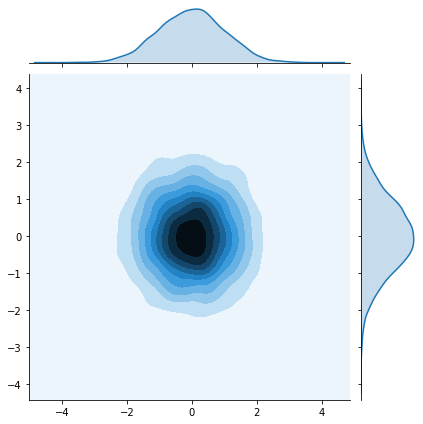

In [9]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
mean = torch.Tensor([0, 0]) # Center the mean at the origin
covariance = torch.Tensor( # This matrix shows independence - there are only non-zero values on the diagonal
    [[1, 0],
     [0, 1]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

Now, here's an example of a multivariate normal distribution that has covariance:

$\Sigma = \left(\begin{array}{cc} 
2 & -1\\ 
-1 & 2
\end{array}\right)
$

And see how it looks:


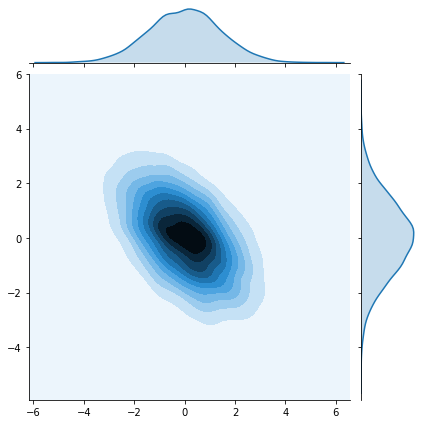

In [10]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

**Formula**

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root. $\mathrm{Tr}$ refers to the trace, the sum of the diagonal elements of a matrix.

In [47]:
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [45]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    return torch.norm(mu_x - mu_y) +torch.trace(sigma_x)+ torch.trace(sigma_y) -2*torch.trace(matrix_sqrt(sigma_x@sigma_y))

## Putting it all together!
Now, you can apply FID to your generator from earlier.

You will start by defining a bit of helper code to preprocess the image for the Inception-v3 network:
<!-- This isn't exactly what FID is meant for, since inception scores expect a natural image, but it should give a rough idea of the diversity and quality of your images.  [TODO: move to bottom since image net is trained on nature (cat, dog) images, fidelity (quality)] -->

In [11]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [12]:
import numpy as np
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

### Get the features of the real and fake images using the Inception-v3 model

In [13]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 # The total number of samples
batch_size = 4 # Samples per iteration

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0
with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

In [26]:
real_features_list[0].mean()

tensor(0.2662)

In [27]:
real_features_list[0].std()

tensor(0.2897)

In [25]:
fake_features_list[0].mean()

tensor(0.3069)

In [28]:
fake_features_list[0].std()

tensor(0.3238)

Then, you can combine all of the values that you collected for the reals and fakes into large tensors:

In [29]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [31]:
fake_features_all.shape

torch.Size([512, 2048])

In [41]:
real_features_all.shape

torch.Size([512, 2048])

And calculate the covariance and means of these real and fake features:

In [48]:
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [49]:
sigma_fake.shape

torch.Size([2048, 2048])

In [50]:
mu_fake.shape

torch.Size([2048])

In [51]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

89.26448059082031


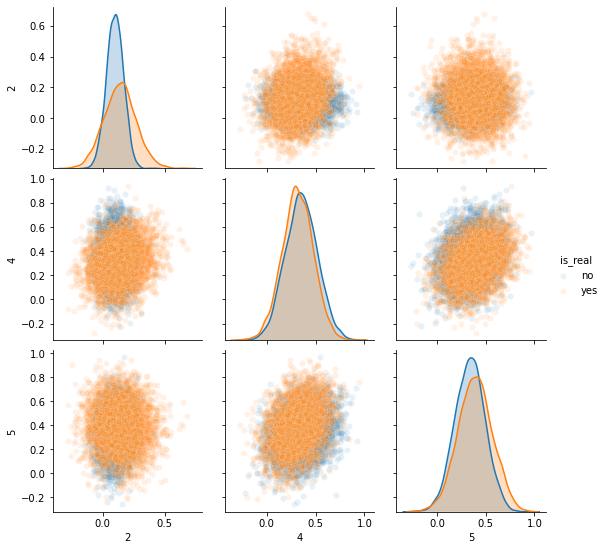

In [52]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')